### Portfolio Risk Management in Python

Here we will see how to analyze return distributions, build portfolios, identify factors driving portfolio returns, and even estimate potential losses.

### Investment risk
- Risk in financial markets is a measure of uncertainty
- Variance of financial returns

#### To measure risk:
- Variance or Standard deviation of daily returns
- Kurtosis of the daily returns distribution
- Skewness of the daily returns distribution
- Historical drawdown

In [1]:
# Libraries needed
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [2]:
stock_price=pd.read_csv('sr_2222.csv', parse_dates=['Date']) # Aramco 
stock_price=stock_price.sort_values(by='Date')
stock_price.set_index('Date', inplace=True)
stock_price

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-02,26.426523,26.575195,26.426523,26.575195,"2,644,521.000000"
2022-01-03,26.500860,26.612366,26.389357,26.389357,"3,409,916.000000"
2022-01-04,26.463694,26.538029,26.426525,26.463694,"2,423,144.000000"
2022-01-05,26.575195,26.612364,26.426523,26.426523,"2,979,819.000000"
2022-01-06,26.352186,26.500858,26.352186,26.463692,"3,839,851.000000"
...,...,...,...,...,...
2025-07-13,24.959999,25.059999,24.940001,25.040001,"4,743,041.000000"
2025-07-14,24.860001,25.000000,24.809999,24.990000,"7,022,781.000000"
2025-07-15,24.600000,24.900000,24.520000,24.860001,"15,453,336.000000"


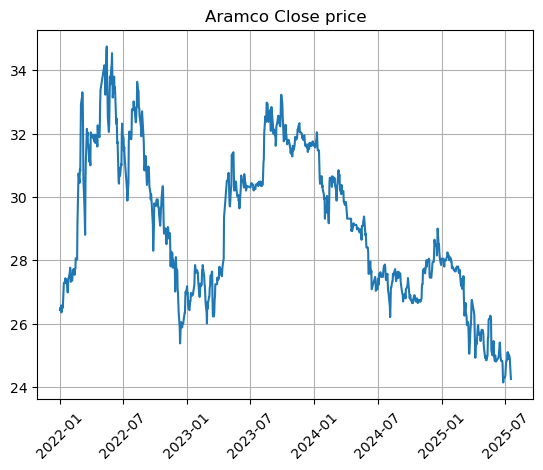

In [3]:
plt.plot(stock_price['Close'])
plt.title('Aramco Close price')
plt.grid()
plt.xticks(rotation=45)
plt.show()

---
#### Calculate daily returns of the Close prices and append the result as a new column

In [4]:
stock_price['Returns']=stock_price['Close'].pct_change()
stock_price=stock_price.dropna().copy()
stock_price.head()

,Close,High,Low,Open,Volume,Returns
Date,,,,,,
2022-01-03,26.500860,26.612366,26.389357,26.389357,"3,409,916.000000",0.002813
2022-01-04,26.463694,26.538029,26.426525,26.463694,"2,423,144.000000",-0.001402
2022-01-05,26.575195,26.612364,26.426523,26.426523,"2,979,819.000000",0.004213
2022-01-06,26.352186,26.500858,26.352186,26.463692,"3,839,851.000000",-0.008392
2022-01-09,26.538027,26.538027,26.389355,26.389355,"4,151,697.000000",0.007052


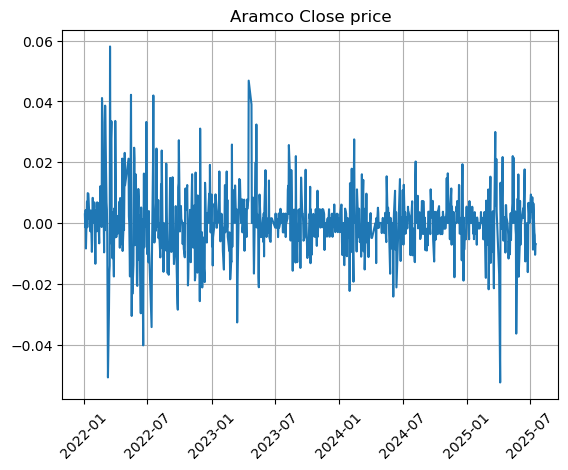

In [5]:
plt.plot(stock_price['Returns'])
plt.title('Aramco Close price')
plt.grid()
plt.xticks(rotation=45)
plt.show()

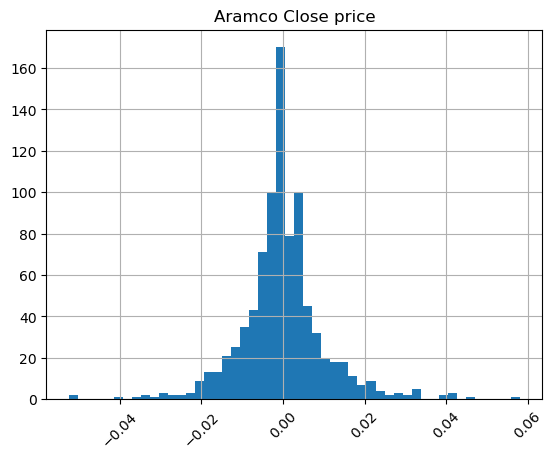

In [6]:
plt.hist(stock_price['Returns'], bins=50, density=False)
plt.title('Aramco Close price')
plt.grid()
plt.xticks(rotation=45)
plt.show()

---
### Moments of distributions
- Mean($ \mu $)
  
    The average outcome of a random sample of the distribution.

- Standard deviation($ \sigma $)

    The measures how spread out a set of numbers is also called volatility

- Variance($ \sigma^2 $)
  
    The measure of the variability in outcomes.

- Skewness
  
    The measure of the "tilt" of a distribution

- Kurtosis

    Is the thickness of the tails of a distribution.

In [7]:
# Calculating mean returns
np.mean(stock_price['Returns'])

-4.3004911275686946e-05

In [8]:
# Caluclating the average annualized return (252 days/year) 
((1+np.mean(stock_price['Returns']))**252)-1

-0.010778956861413502

#### Explanation:
- np.mean(stock_price['Returns']): Computes the average daily return of the stock.
- 1 + mean_daily_return: Converts the return into a growth factor (e.g., a 1% return becomes 1.01).
- **252: Compounds the daily growth factor over 252 trading days (typical number of trading days in a year).
- -1: Converts the compounded growth factor back into a percentage return.

In [9]:
# Calculating the satandard deviation (volatility)
sigma_daily=np.std(stock_price['Returns'])
sigma_daily

0.010477321833907868

In [10]:
# Scaling volatility (Annual)
sigma_annualized=sigma_daily * np.sqrt(252)
sigma_annualized

0.16632232787104442

In [11]:
# Scaling volatility (Monthly)
sigma_monthly=sigma_daily*np.sqrt(21)
sigma_monthly

0.04801312038429634

In [12]:
# Calculating the variance
variance_daily=sigma_daily**2
variance_daily

0.00010977427281128253

In [13]:
# Calculate the annualized variance
variance_annualized=sigma_annualized**2
variance_annualized

0.0276631167484432

In [14]:
# Calculate the skewness of returns
from scipy.stats import skew
skew(stock_price['Returns'].dropna())

0.3570882260469243

In [15]:
# Calculating the excess kurtosis of returns
from scipy.stats import kurtosis

kurtosis(stock_price['Returns'].dropna())
# for real value add 3

4.528367979744662

#### Testing for normality in python
To perform a statistical test for normality use the null hypothesis of the Shapiro_wilk test

In [16]:
from scipy import stats
p_value=stats.shapiro(stock_price['Returns'].dropna())[1]
if p_value <= 0.05:
    print('Null hypothesis of normality is rejected.')
else:
    print('Null hypothesis of normality is acepted.')

p_value

Null hypothesis of normality is rejected.


1.7719160165985735e-20

---
### Portfolio composition and backtesting

In [17]:
# Portfolio consist of BSF, SAB, ALRAJHI, SNB stocks
portfolio_sa=pd.read_csv('portfolio_sa.csv', parse_dates=['Date'])
portfolio_sa.set_index('Date', inplace=True)
portfolio_sa.head()

,1050.SR,1060.SR,1120.SR,1180.SR
Date,,,,
2020-01-01,14.808021,28.244703,35.861488,29.664183
2020-01-02,14.926489,28.409636,36.247093,29.755640
2020-01-05,14.294678,27.626205,35.475880,28.901995
2020-01-06,14.492116,28.409636,35.530972,28.597124
2020-01-07,14.571093,27.791142,35.751316,28.353228


In [18]:
portfolio_sa[['1050.rt', '1060.rt', '1120.rt', '1180.rt']]=portfolio_sa[['1050.SR', '1060.SR', '1120.SR', '1180.SR']].pct_change(fill_method=None)
portfolio_sa.dropna(inplace=True)
portfolio_sa

,1050.SR,1060.SR,1120.SR,1180.SR,1050.rt,1060.rt,1120.rt,1180.rt
Date,,,,,,,,
2020-01-02,14.926489,28.409636,36.247093,29.755640,0.008000,0.005839,0.010753,0.003083
2020-01-05,14.294678,27.626205,35.475880,28.901995,-0.042328,-0.027576,-0.021277,-0.028689
2020-01-06,14.492116,28.409636,35.530972,28.597124,0.013812,0.028358,0.001553,-0.010548
2020-01-07,14.571093,27.791142,35.751316,28.353228,0.005450,-0.021771,0.006201,-0.008529
2020-01-08,14.373652,27.667437,35.420795,28.231274,-0.013550,-0.004451,-0.009245,-0.004301
...,...,...,...,...,...,...,...,...
2025-06-24,17.299999,32.599998,94.099998,35.299999,0.029762,0.031646,0.028415,0.032164
2025-06-25,17.360001,32.750000,93.900002,35.650002,0.003468,0.004601,-0.002125,0.009915
2025-06-26,17.520000,33.250000,94.699997,36.000000,0.009217,0.015267,0.008520,0.009818


In [19]:
# Calculate the portfolio return
portfolio_weights=np.array([0.25, 0.25, 0.25, 0.25])
portfolio_sa['Returns_sum']=portfolio_sa[['1050.rt', '1060.rt', '1120.rt', '1180.rt']].mul(portfolio_weights, axis=1).sum(axis=1)
portfolio_sa.head()

,1050.SR,1060.SR,1120.SR,1180.SR,1050.rt,1060.rt,1120.rt,1180.rt,Returns_sum
Date,,,,,,,,,
2020-01-02,14.926489,28.409636,36.247093,29.755640,0.008000,0.005839,0.010753,0.003083,0.006919
2020-01-05,14.294678,27.626205,35.475880,28.901995,-0.042328,-0.027576,-0.021277,-0.028689,-0.029967
2020-01-06,14.492116,28.409636,35.530972,28.597124,0.013812,0.028358,0.001553,-0.010548,0.008294
2020-01-07,14.571093,27.791142,35.751316,28.353228,0.005450,-0.021771,0.006201,-0.008529,-0.004662
2020-01-08,14.373652,27.667437,35.420795,28.231274,-0.013550,-0.004451,-0.009245,-0.004301,-0.007887


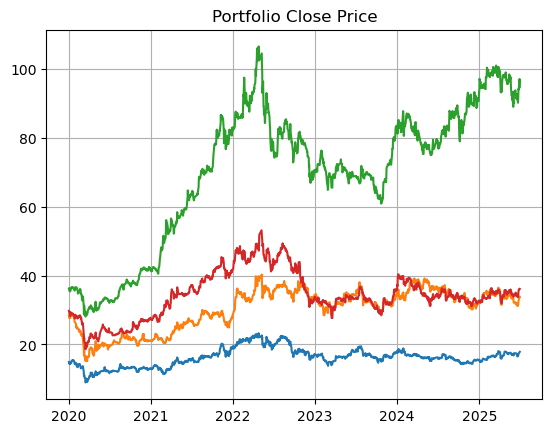

In [20]:
plt.plot(portfolio_sa[['1050.SR', '1060.SR', '1120.SR', '1180.SR']])
plt.title("Portfolio Close Price")
plt.grid()
plt.show()

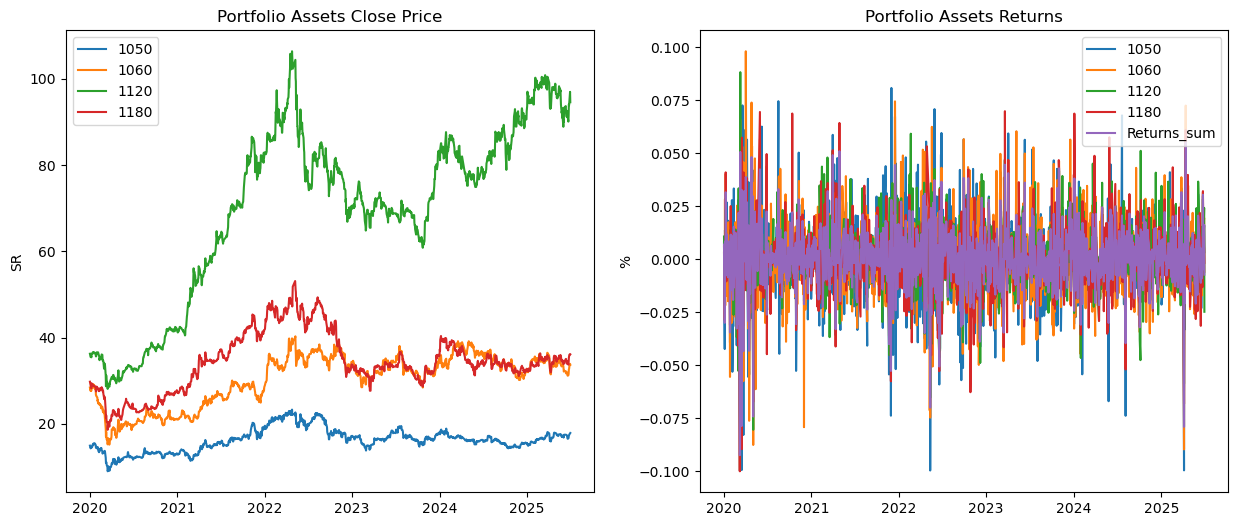

In [21]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(15,6))
ax1.plot(portfolio_sa[['1050.SR', '1060.SR', '1120.SR', '1180.SR']])
ax1.set_title("Portfolio Assets Close Price")
ax1.set_ylabel("SR")
ax1.legend(['1050', '1060', '1120', '1180'])

ax2.plot(portfolio_sa[['1050.rt', '1060.rt', '1120.rt', '1180.rt', 'Returns_sum']])
ax2.set_title("Portfolio Assets Returns")
ax2.set_ylabel("%")
ax2.legend(['1050', '1060', '1120', '1180', 'Returns_sum'])

plt.show()

#### Any good strategy should at least ideally outperform an equally weighted portfolio, which holds the same weight in every stock by default. 

In [22]:
# Calculate equally weighted portfoloio
numstocks=4
portfolio_weights_ew=np.repeat(1/numstocks, numstocks)
portfolio_weights_ew

array([0.25, 0.25, 0.25, 0.25])

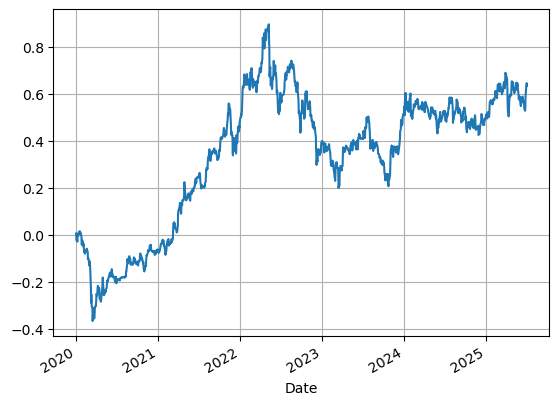

In [23]:
# Plotting portfolio comulative returns
cumulativereturn=((1+portfolio_sa['Returns_sum']).cumprod()-1)
cumulativereturn.plot()
plt.grid(True)
plt.show()

#### Market-cap weighted portfolios

In order to calculate the market-cap weight of a given stock n, divide the market capitalization of that company by the sum of all the market capitalizations of all the stocks in your portfolio.

In [24]:
# Calculate market cap weights
market_capitaliations=np.array([40, 60, 300, 400])
mcap_weights=market_capitaliations/sum(market_capitaliations)
mcap_weights

array([0.05 , 0.075, 0.375, 0.5  ])

In [25]:
# Calculate the portfolio return
portfolio_sa['Returns_sum_mcap']=portfolio_sa[['1050.rt', '1060.rt', '1120.rt', '1180.rt']].mul(mcap_weights, axis=1).sum(axis=1)
portfolio_sa.head(3)

,1050.SR,1060.SR,1120.SR,1180.SR,1050.rt,1060.rt,1120.rt,1180.rt,Returns_sum,Returns_sum_mcap
Date,,,,,,,,,,
2020-01-02,14.926489,28.409636,36.247093,29.755640,0.008000,0.005839,0.010753,0.003083,0.006919,0.006412
2020-01-05,14.294678,27.626205,35.475880,28.901995,-0.042328,-0.027576,-0.021277,-0.028689,-0.029967,-0.026508
2020-01-06,14.492116,28.409636,35.530972,28.597124,0.013812,0.028358,0.001553,-0.010548,0.008294,-0.001874


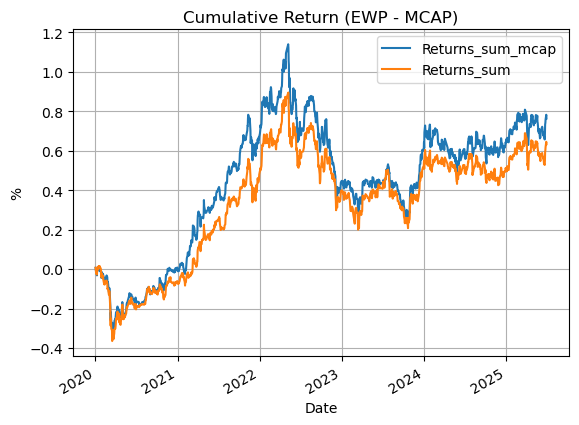

In [26]:
# Plotting portfolio comulative returns (ewp , mcap)
cumulativereturn_mcap=((1+portfolio_sa['Returns_sum_mcap']).cumprod()-1)
cumulativereturn_mcap.plot()
cumulativereturn.plot()
plt.ylabel("%")
plt.title('Cumulative Return (EWP - MCAP)')
plt.legend()
plt.grid(True)
plt.show()

### Correlation and Co-variance
Modern portfolio theory teaches that you can actually build a portfolio of assets which has less risk than any of the underlying assets alone. How is this possible? In short - it's all about correlation and co-variance.

In [27]:
# 
correlation_matrix=portfolio_sa.iloc[:, 4:8].corr()
correlation_matrix

,1050.rt,1060.rt,1120.rt,1180.rt
1050.rt,1.000000,0.536925,0.474411,0.504553
1060.rt,0.536925,1.000000,0.447951,0.526000
1120.rt,0.474411,0.447951,1.000000,0.556411
1180.rt,0.504553,0.526000,0.556411,1.000000


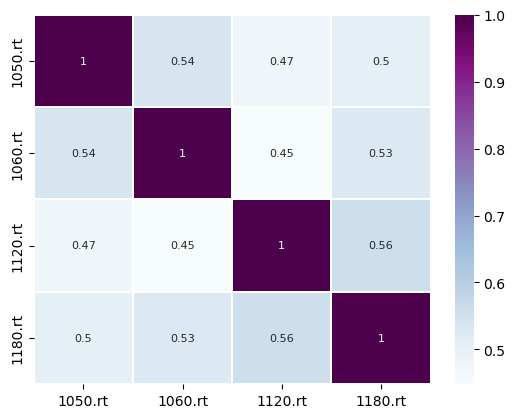

In [28]:
sns.heatmap(correlation_matrix, cmap='BuPu', linewidths=0.3,annot=True, annot_kws={'size':8})
plt.show()

Note that correlation is  a normalized measure of the co-variance.
Co-variance measures the join variability of variables, and in finance the covariance matrix is often used for portfolio optimaization and risk management purposes.

In [29]:
cov_mat=portfolio_sa.iloc[:, 4:8].cov()
cov_mat

,1050.rt,1060.rt,1120.rt,1180.rt
1050.rt,0.000386,0.000200,0.000136,0.000158
1060.rt,0.000200,0.000359,0.000124,0.000159
1120.rt,0.000136,0.000124,0.000213,0.000129
1180.rt,0.000158,0.000159,0.000129,0.000254


In [30]:
cov_mat_annual=cov_mat*252
cov_mat_annual

,1050.rt,1060.rt,1120.rt,1180.rt
1050.rt,0.097283,0.050357,0.034280,0.039793
1060.rt,0.050357,0.090417,0.031204,0.039994
1120.rt,0.034280,0.031204,0.053669,0.032594
1180.rt,0.039793,0.039994,0.032594,0.063940


#### Portfolio standard deviation (Volatility) using Python

In [31]:
# Daily portfolio volatilty
portfolio_volatility=np.sqrt(np.dot(mcap_weights.T, np.dot(cov_mat, mcap_weights)))
portfolio_volatility # daily volatility

0.013350363925459185

In [32]:
# Yearly portfolio volatilty
portfolio_volatility_yearly=np.sqrt(np.dot(mcap_weights.T, np.dot(cov_mat_annual, mcap_weights)))
portfolio_volatility_yearly # daily volatility

0.21193045715383835

### Markpwitz portfolios
#### Sharpe ratio
The Sharpe ratio is a measure of risk-adjusted return

To calculate the Sharpe ratio:
$$ S=(R_a -T_f)/ \sigma_a $$

- S:Sharpe ratio

- $R_a$: Asset return

- $T_f$: Risk-free rate of return

- $ \sigma_a$: Asset volatility

#### Markowitz portfolios
Any poin on the efficient frontier is an optimum portfolio
#### The two common points
- MSR (Max Sharpe Ratio portfolio)
- GMV (Global Minimum Volatility portfolio)

In [33]:
#Generating 1000 Adjusted Portfolios from 4 Assets
np.random.seed(4)
num_portfolios=1000
num_assets=4

# Generate random weights
weights=np.random.random(size=(num_portfolios, num_assets))
weights=weights/weights.sum(axis=1, keepdims=True) # Normalize to sum=1
weights

array([[0.30203048, 0.17091594, 0.30379654, 0.22325704],
       [0.36793775, 0.11395184, 0.51482497, 0.00328544],
       [0.15195579, 0.26116086, 0.46814231, 0.11874105],
       ...,
       [0.28511754, 0.06061252, 0.31980593, 0.33446402],
       [0.35661129, 0.0602829 , 0.0041409 , 0.57896491],
       [0.25261756, 0.22956448, 0.29599452, 0.22182343]])

In [34]:
returns_data=portfolio_sa.iloc[:, 4:8]
returns_data.head(3)

,1050.rt,1060.rt,1120.rt,1180.rt
Date,,,,
2020-01-02,0.008000,0.005839,0.010753,0.003083
2020-01-05,-0.042328,-0.027576,-0.021277,-0.028689
2020-01-06,0.013812,0.028358,0.001553,-0.010548


In [35]:
# Assuming returns_data is a DataFrame with columns = assets, rows = daily returns
cov_matrix = returns_data.cov() * 252  # Annualized covariance (daily data)
mean_returns = returns_data.mean() * 252  # Annualized mean returns (daily data)

portfolio_returns = []
portfolio_volatilities = []

for w in weights:
    # Portfolio return (weighted average)
    ret = np.sum(w * mean_returns)
    # Portfolio volatility (sqrt of weighted covariance)
    vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    
    portfolio_returns.append(ret)
    portfolio_volatilities.append(vol)

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

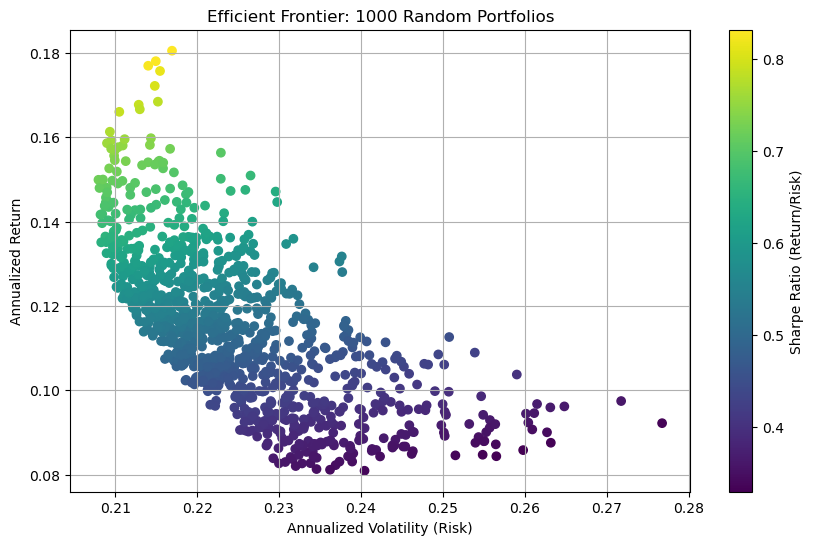

In [36]:
# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_returns / portfolio_volatilities, cmap='viridis', marker='o')
plt.title('Efficient Frontier: 1000 Random Portfolios')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.colorbar(label='Sharpe Ratio (Return/Risk)')
plt.grid(True)
plt.show()

In [37]:
#  Maximum Sharpe Ratio Portfolio (MSR)
sharpe_ratios = portfolio_returns / portfolio_volatilities
max_sharpe_idx = np.argmax(sharpe_ratios)
print("\nMaximum Sharpe Ratio Portfolio:")
print(f"- Weights: {weights[max_sharpe_idx]}")
print(f"- Return: {portfolio_returns[max_sharpe_idx]:.2%}")
print(f"- Volatility: {portfolio_volatilities[max_sharpe_idx]:.2%}")


Maximum Sharpe Ratio Portfolio:
- Weights: [0.12921483 0.08895623 0.76425887 0.01757007]
- Return: 18.05%
- Volatility: 21.69%


In [38]:
# Golobal Minimum Volatility Portfolio (GVP)
min_vol_idx = np.argmin(portfolio_volatilities)
print("Minimum Volatility Portfolio:")
print(f"- Weights: {weights[min_vol_idx]}")
print(f"- Return: {portfolio_returns[min_vol_idx]:.2%}")
print(f"- Volatility: {portfolio_volatilities[min_vol_idx]:.2%}")

Minimum Volatility Portfolio:
- Weights: [0.09986571 0.13838869 0.5348284  0.22691721]
- Return: 14.99%
- Volatility: 20.80%


In [39]:
# MSR
portfolio_weights=np.array([0.12921483, 0.08895623, 0.76425887, 0.01757007])
portfolio_sa['Returns_sum_MSR']=portfolio_sa[['1050.rt', '1060.rt', '1120.rt', '1180.rt']].mul(portfolio_weights, axis=1).sum(axis=1)
portfolio_sa.head(3)

,1050.SR,1060.SR,1120.SR,1180.SR,1050.rt,1060.rt,1120.rt,1180.rt,Returns_sum,Returns_sum_mcap,Returns_sum_MSR
Date,,,,,,,,,,,
2020-01-02,14.926489,28.409636,36.247093,29.755640,0.008000,0.005839,0.010753,0.003083,0.006919,0.006412,0.009825
2020-01-05,14.294678,27.626205,35.475880,28.901995,-0.042328,-0.027576,-0.021277,-0.028689,-0.029967,-0.026508,-0.024687
2020-01-06,14.492116,28.409636,35.530972,28.597124,0.013812,0.028358,0.001553,-0.010548,0.008294,-0.001874,0.005309


In [40]:
# GVP
portfolio_weights=np.array([0.09986571, 0.13838869, 0.5348284, 0.22691721])
portfolio_sa['Returns_sum_GVP']=portfolio_sa[['1050.rt', '1060.rt', '1120.rt', '1180.rt']].mul(portfolio_weights, axis=1).sum(axis=1)

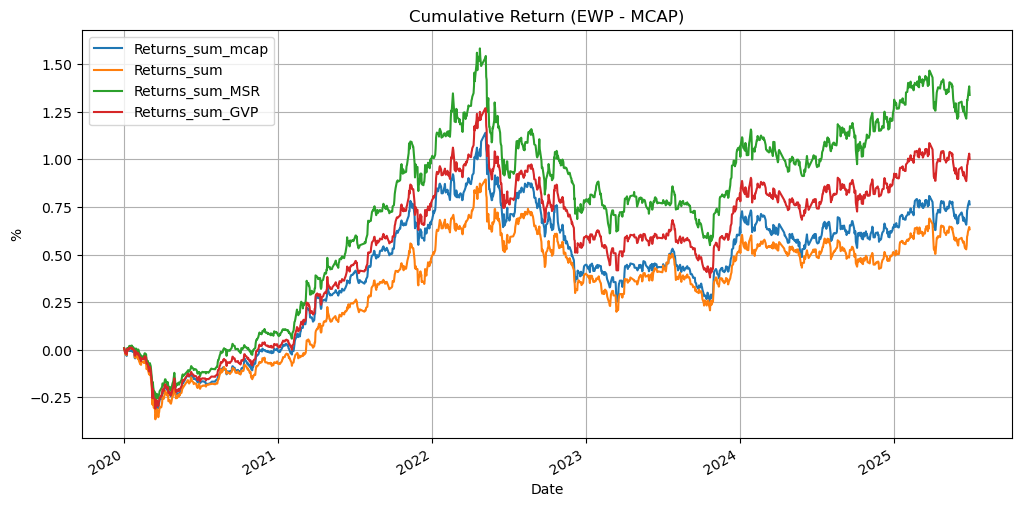

In [41]:
# Plotting portfolio comulative returns (ewp , mcap)
plt.figure(figsize=(12, 6))
cumulativereturn_MSR=((1+portfolio_sa['Returns_sum_MSR']).cumprod()-1)
cumulativereturn_GVP=((1+portfolio_sa['Returns_sum_GVP']).cumprod()-1)
cumulativereturn_mcap.plot()
cumulativereturn.plot()
cumulativereturn_MSR.plot()
cumulativereturn_GVP.plot()

plt.ylabel("%")
plt.title('Cumulative Return (EWP - MCAP)')
plt.legend()
plt.grid(True)
plt.show()

### Factor Investing
#### The Capital Asset Pricing model
The Capital Asset Pricing Model is the fundamental building block for many other asset pricing models and factor models in finance
                                                                 

In [42]:
FamaFrenchData=pd.read_csv('Fama-French.txt', parse_dates=['Date'])
FamaFrenchData.set_index(['Date'], inplace=True)
FamaFrenchData

,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.00000
2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.00000
2013-01-07,0.004421,-0.0031,-0.0009,-0.0037,-0.0013,-0.0012,0.00000
2013-01-08,-0.004659,-0.0027,0.0004,-0.0007,-0.0012,0.0009,0.00000
2013-01-09,0.004636,0.0034,0.0024,-0.0041,-0.0007,-0.0015,0.00000
...,...,...,...,...,...,...,...
2017-12-22,-0.001360,-0.0007,-0.0019,-0.0020,-0.0005,0.0021,0.00004
2017-12-26,-0.002715,-0.0007,0.0031,-0.0006,-0.0017,0.0056,0.00004
2017-12-27,0.001651,0.0005,-0.0016,-0.0019,0.0006,-0.0012,0.00004


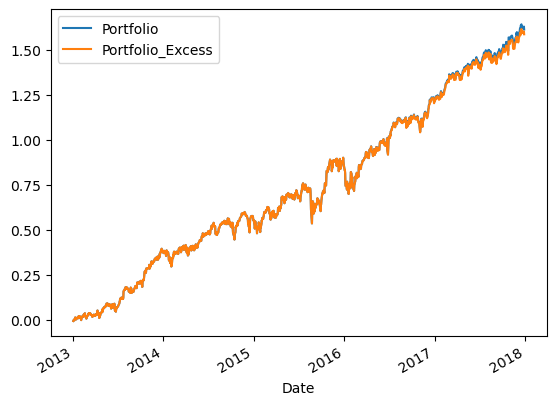

In [43]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio']-FamaFrenchData['RF']

# Plot returns vs excess returns
CumulativeReturns = ((1+FamaFrenchData[['Portfolio','Portfolio_Excess']]).cumprod()-1)
CumulativeReturns.plot()
plt.legend()
plt.show()

In [44]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
print(covariance_coefficient)

# Calculate the benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()
print(benchmark_variance)

# Calculating the portfolio market beta
portfolio_beta = covariance_coefficient/benchmark_variance
print(portfolio_beta)

5.726126338154967e-05
5.8803350882118946e-05
0.9737755165745461


In [45]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=FamaFrenchData)

# Print adjusted r-squared of the fitted regression
CAPM_fit = CAPM_model.fit()
print(CAPM_fit.rsquared_adj)

# Extract the beta
regression_beta = CAPM_fit.params['Market_Excess']
print(regression_beta)

0.7942627160017839
0.973775516574546


#### The Fama French 3-factor model
The Fama-French model famously adds two additional factors to the CAPM model to describe asset returns:

$ R_p=RF + \beta_m(R_m-RF) + b_{SMP} .SMB + b_{HML}.HML + \alpha$

SMB: The small minus big factor
: Exposure to the SMB factor
HML: The high minus low factor
: Exposure to the HML factor
: Performance which is unexplained by any other factors
: Beta to the broad market portfolio B

In [46]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)

# Fit the regression
FamaFrench_fit = FamaFrench_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench_fit.rsquared_adj
print(regression_adj_rsq)

0.8193910088585152


### p-values and coefficients
You can use the .pvalues attribute on a fitted smf.ols regression model to retrieve the p-values for each coefficient.

Normally, p-values less than 0.05 are considered statistically significant.

Coefficients can be extracted from the fitted regression object using the .params attribute.

In [47]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = FamaFrench_fit.params['SMB']
print("The SMB coefficient is ", smb_coeff, " and is ", significant_msg)

The SMB coefficient is  -0.2621515274319262  and is  significant


#### The efficient market and alpha
The alpha ($\alpha$) left over by the regression is unexplained performance due to unknown factors. In a regression model, this is simply the coefficient of the intercept.

There are two general schools of thought as to why:

The model simply needs to be expanded. When you have found all of the missing economic factors, you can explain all stock and portfolio returns. This is known as the Efficient Market Hypothesis.

There is a degree of unexplainable performance that no model will ever capture reliably. Perhaps it is due to skill, timing, intuition or luck, but investors should seek to maximize their alpha.

In [48]:
# Calculate your portfolio alpha
portfolio_alpha = FamaFrench_fit.params['Intercept']
print(portfolio_alpha)

# Annualize your portfolio alpha
portfolio_alpha_annualized = ((1+portfolio_alpha)**252)-1
print(portfolio_alpha_annualized)

0.00018326665203183045
0.04726181730280854


#### RMW
The RMW factor represents the returns of companies with high operating profitability versus those with low operating profitability
#### CMA
the CMA factor represents the returns of companies with aggressive investments versus those who are more conservative

In [49]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
FamaFrench5_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML + RMW + CMA ', data=FamaFrenchData)

# Fit the regression
FamaFrench5_fit = FamaFrench5_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench5_fit.rsquared_adj
print(regression_adj_rsq)

0.8367245019225793


### VaR, CVaR, and Monte-Carlo simulation
#### A key component of portfolio risk management is being able to define risk beyond simple measures such as std, var, and kurtosis
#### Estimating tail risk
Tail risk is the risk of extreme investment outcomes, most notably on the negative side of a distribution.
- Historical Drawdown
- VaR
- CVaR
- Monte-Carlo simulation

In [50]:
cum_rets=pd.read_csv("ETF of oil price.txt", parse_dates=['Date'])
cum_rets.set_index('Date', inplace=True)
StockReturns=cum_rets.copy()

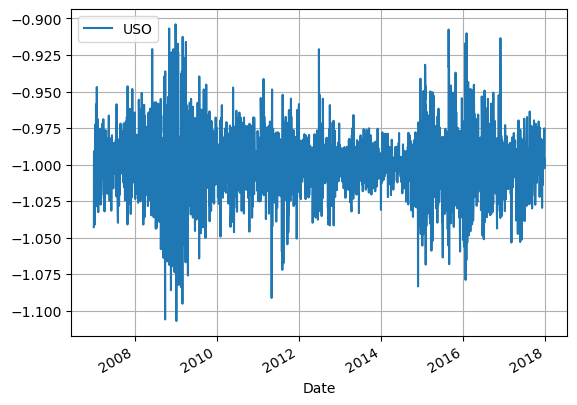

In [51]:
# Historical drawdown

# Calculate the running maximum
running_max = np.maximum.accumulate(cum_rets)

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cum_rets)/running_max - 1

# Plot the results
drawdown.plot()
plt.grid()
plt.show()

In [52]:
var_level = 95
var_95 = np.quantile(portfolio_sa['Returns_sum'], 1 - var_level/100)  # Convert percentile to 0-1 range
cvar_95 = portfolio_sa['Returns_sum'][portfolio_sa['Returns_sum'] <= var_95].mean()
print(f"VaR (95%): {var_95:.4f}")
print(f"CVaR (95%): {cvar_95:.4f}")

VaR (95%): -0.0200
CVaR (95%): -0.0335


#### Explanation
#### VaR (Value-at-Risk)
Definition: The worst loss not exceeded with a given confidence (e.g., 95%).

VaR (95%) = -0.0200 (5% of returns are worse than -2%).

#### CVaR (Conditional VaR)
Definition: The average loss beyond the VaR threshold (also called "Expected Shortfall").

CVaR (95%) = -0.0335 (since only one return ≤ VaR).

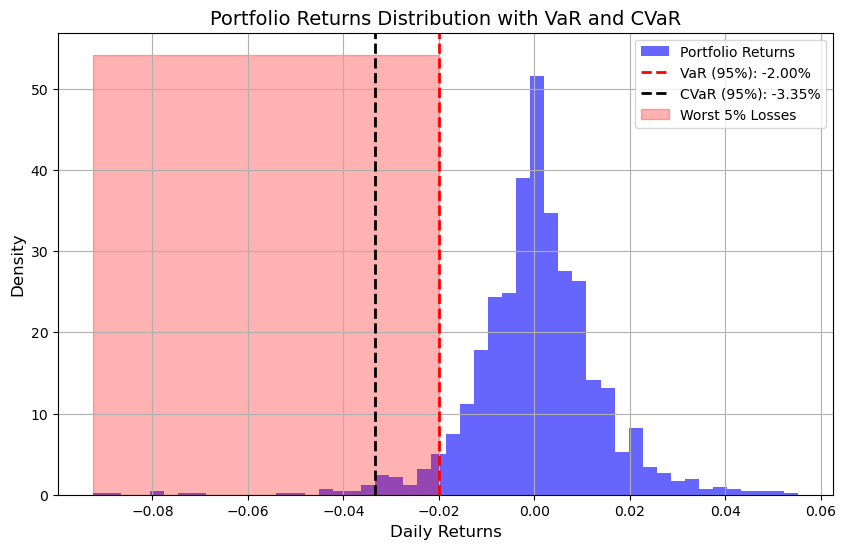

In [53]:

# Plot histogram of returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_sa['Returns_sum'], bins=50, density=True, alpha=0.6, color='blue', label='Portfolio Returns')

# Add VaR and CVaR lines
plt.axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): {var_95:.2%}')
plt.axvline(cvar_95, color='black', linestyle='--', linewidth=2, label=f'CVaR (95%): {cvar_95:.2%}')

# Highlight the tail losses (for CVaR)
plt.fill_betweenx(
    y=[0, plt.ylim()[1]],  # Vertical range
    x1=portfolio_sa['Returns_sum'].min(),  # Left boundary
    x2=var_95,  # Right boundary (VaR)
    color='red',
    alpha=0.3,
    label='Worst 5% Losses'
)

# Customize plot
plt.title('Portfolio Returns Distribution with VaR and CVaR', fontsize=14)
plt.xlabel('Daily Returns', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### Random walks

Random, or stochastic, movements are apparent throughout nature. From tidal waves and earthquakes to crime, particle physics, and yes - of course - the stock market, you can use mathematics to predict the future and simulate possible outcomes. Of course, there is always going to be a measure of uncertainty to most of these examples, and especially in finance - but the process is still incredibly useful. There's a surprising amount of crossover between different stochastic methods for fields ranging from geophysics and quantum physics to biology and even sociology. 

C:\Users\abdul\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


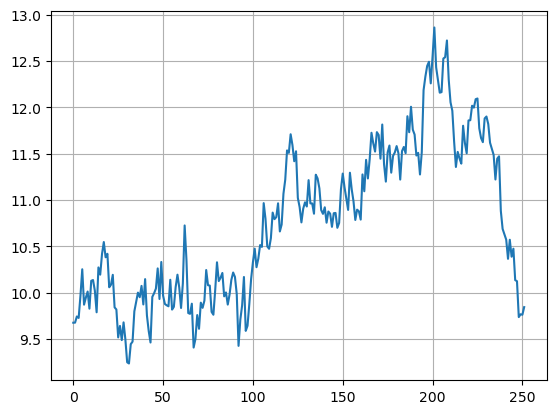

In [54]:
# Set the simulation parameters
mu = np.mean(StockReturns)
vol = np.std(StockReturns)
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu, vol, T) + 1

# Forecasted random walk
forecasted_values = S0*rand_rets.cumprod()

# Plot the random walk
plt.plot(range(0, T), forecasted_values)
plt.grid()
plt.show()

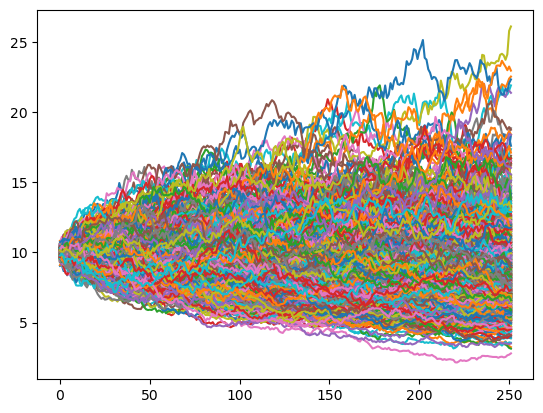

In [55]:
# Loop through 100 simulations
for i in range(1000):

    # Generate the random returns
    rand_rets = np.random.normal(mu, vol, T) + 1
    
    # Create the Monte carlo path
    forecasted_values = S0*(rand_rets).cumprod()
    
    # Plot the Monte Carlo path
    plt.plot(range(T), forecasted_values,)

# Show the simulations
plt.show()

We covered 
- Moments and Distributions
- Portfolio composition
- Correlation and Co-Variance
- Markowitz Optimization
- Beta & CAPM
- FAMA French factor Modeling
- Alpha
- Value at Risk and CVaR
- Monte Carlo Simulations